머신러닝 실습 - 백화점 고객의 1년 간 구매 데이터

예측모델 만들기

라이브러리 불러오기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

데이터 불러오기

In [2]:
X_df = pd.read_csv('./data/X.csv',encoding ='cp949')
y_df = pd.read_csv('./data/y.csv',encoding ='cp949')

In [3]:
# 데이터 정보보기
X_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cust_id  3500 non-null   int64  
 1   총구매액     3500 non-null   int64  
 2   최대구매액    3500 non-null   int64  
 3   환불금액     1205 non-null   float64
 4   주구매상품    3500 non-null   object 
 5   주구매지점    3500 non-null   object 
 6   내점일수     3500 non-null   int64  
 7   내점당구매건수  3500 non-null   float64
 8   주말방문비율   3500 non-null   float64
 9   구매주기     3500 non-null   int64  
dtypes: float64(3), int64(5), object(2)
memory usage: 273.6+ KB


In [4]:
# X, y데이터 합치기
df = pd.merge(X_df, y_df,on='cust_id')

In [6]:
# 범주형 타입은 빼고 상관계수 구해보기
df1 = df.drop(columns = ['주구매상품','주구매지점'])
df1.corr()

,cust_id,총구매액,최대구매액,환불금액,내점일수,내점당구매건수,주말방문비율,구매주기,gender
cust_id,1.000000,-0.008004,-0.005883,0.070135,-0.025234,-0.004840,0.001900,0.020070,-0.001994
총구매액,-0.008004,1.000000,0.700080,0.419734,0.659084,0.090022,0.014396,-0.212944,-0.150141
최대구매액,-0.005883,0.700080,1.000000,0.410562,0.374147,0.018980,0.022277,-0.115837,-0.114323
환불금액,0.070135,0.419734,0.410562,1.000000,0.270290,-0.063114,-0.062397,-0.211125,-0.078025
내점일수,-0.025234,0.659084,0.374147,0.270290,1.000000,0.225264,-0.010325,-0.293200,-0.155000
내점당구매건수,-0.004840,0.090022,0.018980,-0.063114,0.225264,1.000000,0.007659,-0.091151,-0.043917
주말방문비율,0.001900,0.014396,0.022277,-0.062397,-0.010325,0.007659,1.000000,0.003372,0.073598
구매주기,0.020070,-0.212944,-0.115837,-0.211125,-0.293200,-0.091151,0.003372,1.000000,0.041450
gender,-0.001994,-0.150141,-0.114323,-0.078025,-0.155000,-0.043917,0.073598,0.041450,1.000000


1. 환불금액이 성별과 직접적인 관련이 없는 것으로 판단, -0.078025

2. 환불금액은 총 구매액과 관련이 있는 것으로 판단, 	0.419734 

3. 결론: 환불금액과 총구매액을 얽어서 결측치 처리를 하기로 하였음
-> NULL처리: 성별에 따라 환불비율(총구매액/환불금액)을 구해서 환불금액이 없는 값에 (총구매액* 환불비율) 해서 NULL값 처리

In [7]:
# 환불 비율 컬럼 만들기
df['환불비율'] = np.where(df['총구매액'] == 0, np.nan, df['환불금액'] / df['총구매액'])

# 성별별 평균 환불 비율 계산
성별별_평균비율 = df.groupby('gender')['환불비율'].mean()

# 환불금액 결측치 채우는 함수
def fill_refund(row):
    if pd.isna(row['환불금액']):
        if row['총구매액'] == 0:
            return 0  # 총구매액이 0이면 환불금액은 0
        else:
            평균비율 = 성별별_평균비율[row['gender']]
            return row['총구매액'] * 평균비율
    else:
        return row['환불금액']

# 환불금액 컬럼 채우기
df['환불금액'] = df.apply(fill_refund, axis=1)


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cust_id  3500 non-null   int64  
 1   총구매액     3500 non-null   int64  
 2   최대구매액    3500 non-null   int64  
 3   환불금액     3500 non-null   float64
 4   주구매상품    3500 non-null   object 
 5   주구매지점    3500 non-null   object 
 6   내점일수     3500 non-null   int64  
 7   내점당구매건수  3500 non-null   float64
 8   주말방문비율   3500 non-null   float64
 9   구매주기     3500 non-null   int64  
 10  gender   3500 non-null   int64  
 11  환불비율     1198 non-null   float64
dtypes: float64(4), int64(6), object(2)
memory usage: 328.2+ KB


In [9]:
df2 = df.drop(columns = ['주구매상품','주구매지점'])
df2.corr()

,cust_id,총구매액,최대구매액,환불금액,내점일수,내점당구매건수,주말방문비율,구매주기,gender,환불비율
cust_id,1.000000,-0.008004,-0.005883,0.003055,-0.025234,-0.004840,0.001900,0.020070,-0.001994,-0.010526
총구매액,-0.008004,1.000000,0.700080,0.493755,0.659084,0.090022,0.014396,-0.212944,-0.150141,-0.053382
최대구매액,-0.005883,0.700080,1.000000,0.420870,0.374147,0.018980,0.022277,-0.115837,-0.114323,-0.018964
환불금액,0.003055,0.493755,0.420870,1.000000,0.265757,0.057646,0.012126,-0.092123,-0.182241,-0.008083
내점일수,-0.025234,0.659084,0.374147,0.265757,1.000000,0.225264,-0.010325,-0.293200,-0.155000,-0.065213
내점당구매건수,-0.004840,0.090022,0.018980,0.057646,0.225264,1.000000,0.007659,-0.091151,-0.043917,-0.053728
주말방문비율,0.001900,0.014396,0.022277,0.012126,-0.010325,0.007659,1.000000,0.003372,0.073598,-0.039737
구매주기,0.020070,-0.212944,-0.115837,-0.092123,-0.293200,-0.091151,0.003372,1.000000,0.041450,0.141095
gender,-0.001994,-0.150141,-0.114323,-0.182241,-0.155000,-0.043917,0.073598,0.041450,1.000000,-0.019230
환불비율,-0.010526,-0.053382,-0.018964,-0.008083,-0.065213,-0.053728,-0.039737,0.141095,-0.019230,1.000000


주구매지점과 주구매상품이 성별과 연관이 있나 궁금했음..

In [18]:
from matplotlib import rcParams  # 폰트지정
rcParams['font.family'] = 'Gulim'
rcParams['axes.unicode_minus'] = False

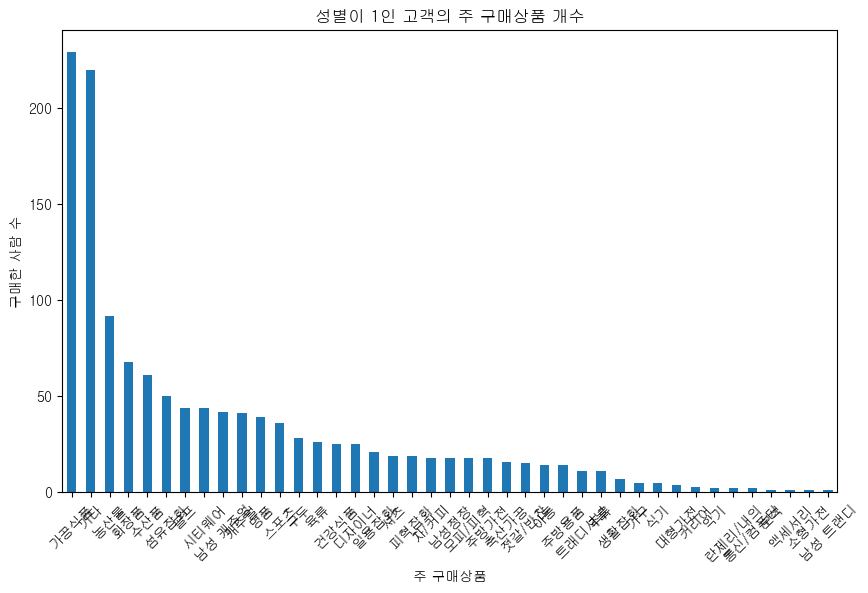

In [20]:
# 주구매 상품과 지점을 성별에 따라 숫자세기
# 성별=1
df_1 = df[df['gender'] == 1]
product_counts_1 = df_1['주구매상품'].value_counts()

plt.figure(figsize=(10, 6))
product_counts_1.plot(kind='bar')

plt.title('성별이 1인 고객의 주 구매상품 개수')
plt.xlabel('주 구매상품')
plt.ylabel('구매한 사람 수')
plt.xticks(rotation=45)
plt.show()

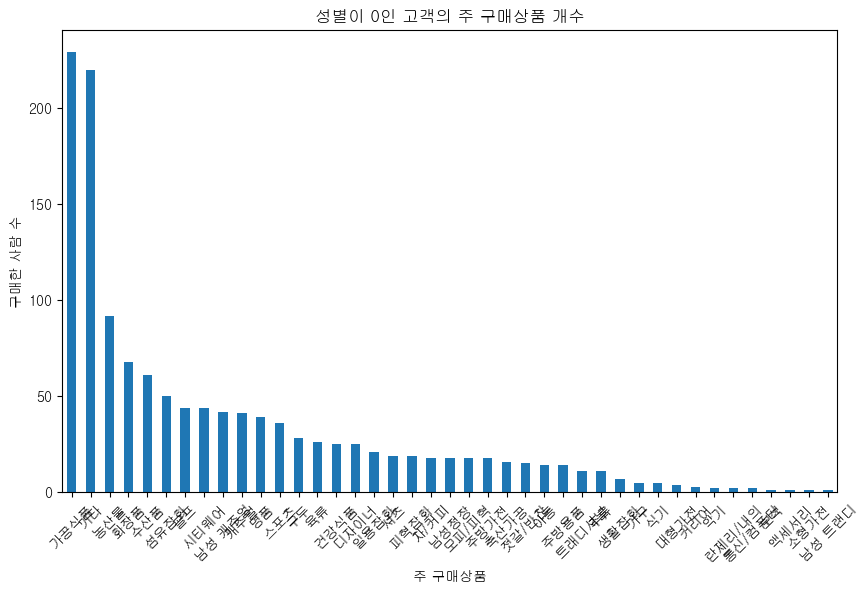

In [21]:
# 주구매 상품과 지점을 성별에 따라 숫자세기
# 성별=0
df_0 = df[df['gender'] == 1]
product_counts_0 = df_0['주구매상품'].value_counts()

plt.figure(figsize=(10, 6))
product_counts_0.plot(kind='bar')

plt.title('성별이 0인 고객의 주 구매상품 개수')
plt.xlabel('주 구매상품')
plt.ylabel('구매한 사람 수')
plt.xticks(rotation=45)
plt.show()

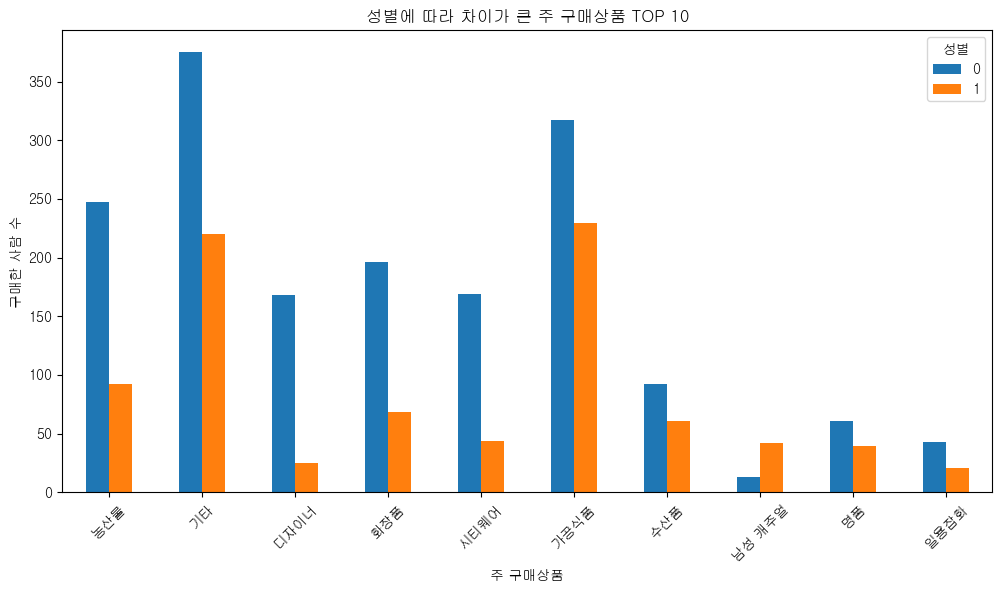

In [24]:
import matplotlib.pyplot as plt

cross_tab = pd.crosstab(df['주구매상품'], df['gender'])
cross_tab.columns = ['0', '1']
cross_tab['차이'] = abs(cross_tab['0'] - cross_tab['1'])

top10_diff = cross_tab.sort_values(by='차이', ascending=False).head(10)
top10_diff[['0', '1']].plot(kind='bar', figsize=(12, 6))

plt.title('성별에 따라 차이가 큰 주 구매상품 TOP 10')
plt.xlabel('주 구매상품')
plt.ylabel('구매한 사람 수')
plt.xticks(rotation=45)
plt.legend(title='성별')
plt.show()

결론: 주 구매상품에 대한 성별에 대한 차이가 있다고 생각했음.

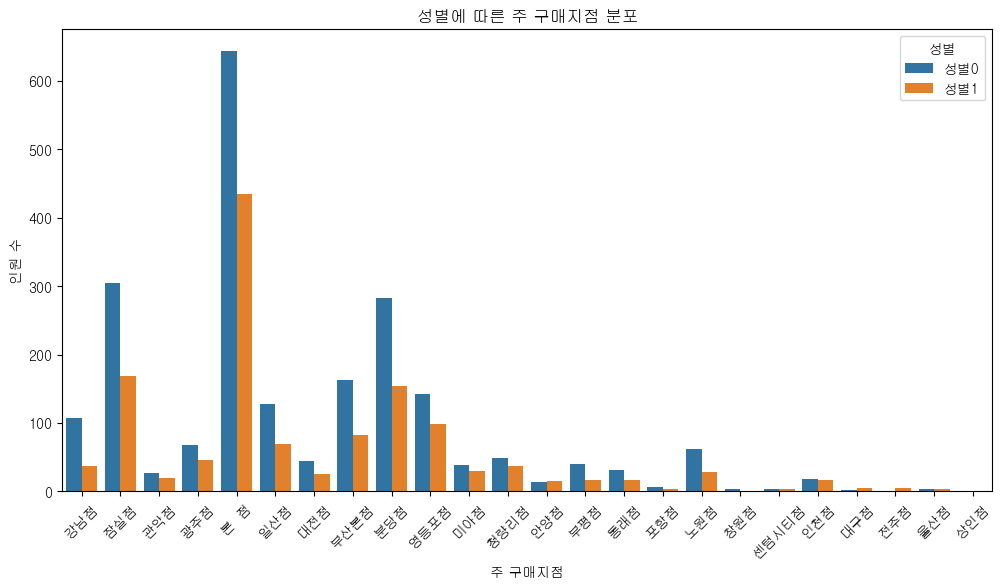

In [26]:
# 구매지점에 따른 성별에 대한 차이가 있을까?
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='주구매지점', hue='gender')

plt.title('성별에 따른 주 구매지점 분포')
plt.xlabel('주 구매지점')
plt.ylabel('인원 수')
plt.xticks(rotation=45)
plt.legend(title='성별', labels=['성별0', '성별1'])
plt.show()

주구매지점 또한 성별에 따른 차이가 있다고 생각.

타입이 objcet 인 속성 라벨링하기

In [10]:
# 주구매상품
cross_tab = pd.crosstab(df['주구매상품'], df['gender'])

# 차이가 큰 1~8까지 라벨링, 나머지는 전부 9로 라벨링
cross_tab['차이'] = abs(cross_tab[0] - cross_tab[1])
cross_tab = cross_tab.sort_values(by='차이', ascending=False).reset_index()

# 우선 라벨링 컬럼 기본값 9로 설정
cross_tab['label'] = 9

# 상위 8개는 1~8로 라벨링
cross_tab.loc[:7, 'label'] = range(1, 9)

# 차이가 22 이하인 항목은 전부 9 (이미 기본값이므로 따로 안 해도 됨)
cross_tab.loc[cross_tab['차이'] <= 22, 'label'] = 9

# cross_tab에서 주 구매상품과 라벨만 추출
product_labels = cross_tab[['주구매상품', 'label']]

# 원본 df에 merge
df = df.merge(product_labels, on='주구매상품', how='left')

In [11]:
# 주구매지점
cross_tab = pd.crosstab(df['주구매지점'], df['gender'])

# 차이 계산 (컬럼명이 숫자 0, 1인 경우)
cross_tab['차이'] = abs(cross_tab[0] - cross_tab[1])

cross_tab = cross_tab.sort_values(by='차이', ascending=False).reset_index()

cross_tab['label'] = 6
cross_tab.loc[:4, 'label'] = range(1, 6)

product_labels = cross_tab[['주구매지점', 'label']]
df = df.merge(product_labels, on='주구매지점', how='left')

In [13]:
df3 = df.rename(columns = {'label_x':'주구매상품_label','label_y':'주구매지점_label'})

In [14]:
df3

,cust_id,총구매액,최대구매액,환불금액,주구매상품,주구매지점,내점일수,내점당구매건수,주말방문비율,구매주기,gender,환불비율,주구매상품_label,주구매지점_label
0,0,68282840,11264000,6.860000e+06,기타,강남점,19,3.894737,0.527027,17,0,0.100464,2,5
1,1,2136000,2136000,3.000000e+05,스포츠,잠실점,2,1.500000,0.000000,1,0,0.140449,9,2
2,2,3197000,1639000,1.390199e+06,남성 캐주얼,관악점,2,2.000000,0.000000,1,1,NaN,8,6
3,3,16077620,4935000,6.991269e+06,기타,광주점,18,2.444444,0.318182,16,1,NaN,2,6
4,4,29050000,24000000,2.519406e+07,보석,본 점,2,1.500000,0.000000,85,0,NaN,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,3495,3175200,3042900,1.380719e+06,골프,본 점,1,2.000000,1.000000,0,1,NaN,9,1
3496,3496,29628600,7200000,6.049600e+06,시티웨어,부산본점,8,1.625000,0.461538,40,1,0.204181,5,4
3497,3497,75000,75000,6.504489e+04,주방용품,창원점,1,1.000000,0.000000,0,0,NaN,9,6
3498,3498,1875000,1000000,1.626122e+06,화장품,본 점,2,1.000000,0.000000,39,0,NaN,4,1


In [ ]:
X = df3.drop(columns=['cust_id','주구매상품','주구매지점','gender','환불비율'])
y = df3['gender']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # train 데이터에 맞춰 학습 후 변환
X_test = scaler.transform(X_test)        # test 데이터는 학습한 스케일러로 변환만

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

models = {
    'RandomForest': RandomForestClassifier(n_estimators=100), 
    'DecisionTree': DecisionTreeClassifier(),
    'LogisticRegression': LogisticRegression(max_iter=1000)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    acc = accuracy_score(y_test, pred)
    print(f"{name} 정확도: {acc:.4f}")

RandomForest 정확도: 0.8200
DecisionTree 정확도: 0.8100
LogisticRegression 정확도: 0.6357


In [29]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# DMatrix로 변환 (XGBoost 내부 데이터 구조)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# 파라미터 설정 (이진 분류 예)
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 6,               # 깊이 늘려서 복잡도 ↑
    'eta': 0.05,                  # 학습률 ↓
    'subsample': 0.8,             # 샘플 일부만 사용 → 과적합 방지
    'colsample_bytree': 0.8,      # 피처 일부만 사용 → 과적합 방지
    'gamma': 0.1,                 # 무분별한 분할 방지
    'min_child_weight': 1,        # 잎 노드 샘플 최소치
    'seed': 42
}

# 학습
num_round = 100
bst = xgb.train(params, dtrain, num_boost_round=num_round)

# 예측 (확률 반환)
pred_prob = bst.predict(dtest)
# 이진 분류로 변환 (threshold=0.5)
pred = (pred_prob > 0.5).astype(int)

# 정확도 출력
acc = accuracy_score(y_test, pred)
print(f'XGBoost 정확도: {acc:.4f}')

XGBoost 정확도: 0.8600
